# Research Agent 

*The goal of research is to gather the context requested by the research brief.*

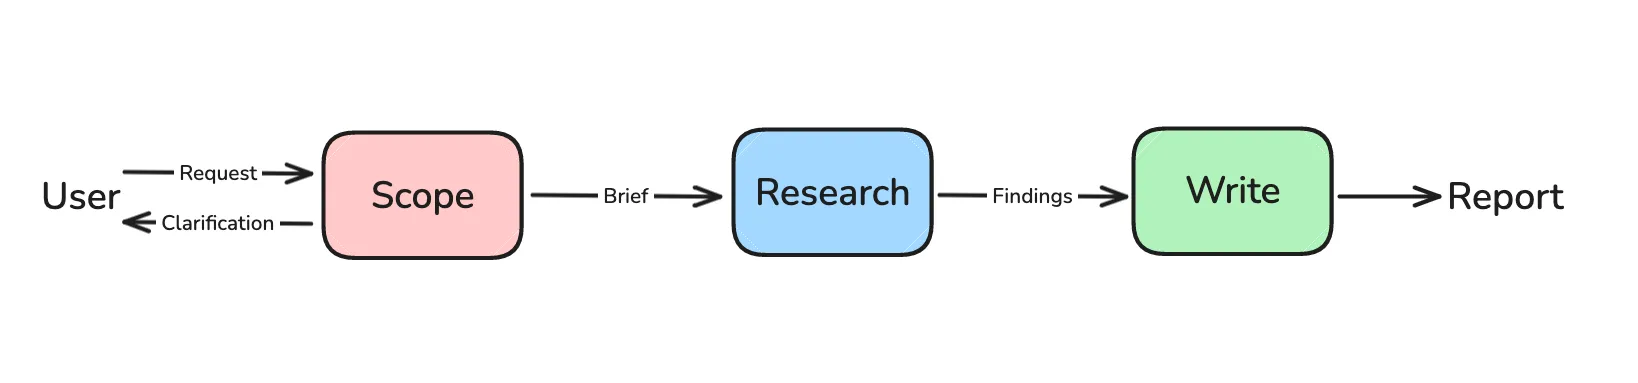

Let's build an agent that is capable of performing research on a given research brief.

## Agents for Research

Research is an open‑ended task; the best strategy to answer a user request can’t be easily known in advance. Requests can require different research strategies and varying levels of search depth. Consider this request:

> *“Compare these two products”*

Comparisons typically benefit from search on each product, followed by a synthesis step to compare them. Now, consider this one:

> *“Is X really true?”*

Listing and ranking requests typically require open-ended search, followed by a synthesis and ranking.
 
[Agents](https://langchain-ai.github.io/langgraph/tutorials/workflows/#agent) are well suited to research because they can flexibly apply different strategies, using intermediate results to guide their exploration.

## Agent with Custom Tools

Let's define an [agent](https://langchain-ai.github.io/langgraph/tutorials/workflows/#agent) that will call custom search tools in a loop:

1. **LLM Call**: The model decides whether to call a tool or provide a final answer
2. **Tool Execution**: If tools are called, they are executed and results are gathered
3. **Iteration**: The model receives tool results and decides next steps
4. **Termination**: The loop continues until the model decides it has enough information

### Prompt

First, we'll define a prompt that instructs our agent to use available search tools. 

In [25]:
from rich.markdown import Markdown
from deep_research_from_scratch.prompts import research_agent_prompt
Markdown(research_agent_prompt)

You are a research assistant conducting thorough research on user queries. Your goal is to provide comprehensive,  
well-sourced answers.                                                                                              

RESEARCH GUIDELINES:                                                                                               

 1 Use search tools to gather current and relevant information                                                     
 2 Search for multiple perspectives and sources when possible                                                      
 3 Cite sources clearly in your responses                                                                          
 4 Be thorough but efficient - don't make unnecessary searches                                                     
 5 If initial searches are insufficient, make additional targeted searches                                         

SEARCH STRATEGY:                                                                                                   

 • Start with broad searches to understand the topic                                                               
 • Follow up with specific searches for details or clarification                                                   
 • Look for authoritative sources and recent information                                                           
 • Consider different viewpoints and potential biases                                                              

RESPONSE FORMAT:                                                                                                   

 • Provide clear, well-structured answers                                                                          
 • Include specific facts and data points                                                                          
 • Cite sources using ]8;id=23126;URL\Source Name]8;;\ format                                                                           
 • Acknowledge limitations or uncertainties when appropriate                                                       

When you have enough information to provide a comprehensive answer, stop searching and provide your final response.

### State and Schemas

The state object and schema are similar to what we had in the previous notebook. 

We only add a schema, Summary, to store the summary of the search tool feedback. 


In [26]:
%%writefile ../src/deep_research_from_scratch/state.py

from typing import Optional
from pydantic import BaseModel, Field
from langgraph.graph import MessagesState

class AgentState(MessagesState):
    research_brief: Optional[str]

class ClarifyWithUser(BaseModel):
    need_clarification: bool = Field(
        description="Whether the user needs to be asked a clarifying question.",
    )
    question: str = Field(
        description="A question to ask the user to clarify the report scope",
    )
    verification: str = Field(
        description="Verify message that we will start research after the user has provided the necessary information.",
    )

class ResearchQuestion(BaseModel):
    research_brief: str = Field(
        description="A research question that will be used to guide the research.",
    )

class Summary(BaseModel):
    summary: str
    key_excerpts: str

Overwriting ../src/deep_research_from_scratch/state.py


### Research Tool

Now, we'll define our research tool! 

#### Tavily SDK Integration

We'll use the [Tavily SDK](https://docs.tavily.com/sdk/python/reference) to perform web searches. Tavily is a search engine optimized for AI applications, providing:
- Real-time web search results
- Content extraction and summarization
- Domain filtering and result ranking
- Async support for performance

####  LangChain Tools

We'll convert our Tavily search function into a [LangChain tool](https://python.langchain.com/docs/concepts/tools/) using the `@tool` decorator. This enables:
- Automatic schema generation for the LLM
- Integration with LangChain's agent framework
- Standardized tool calling interface
- Type validation and documentation

####  InjectedToolArg

The `InjectedToolArg` annotation allows us to inject runtime configuration into tools without exposing these parameters to the LLM. This is useful for:
- API keys and configuration
- Runtime settings (max_results, topic filters)
- System-level parameters the LLM shouldn't control

This keeps the tool interface clean for the LLM while allowing flexible configuration.

In [27]:
%%writefile ../src/deep_research_from_scratch/utils.py

import asyncio
from datetime import datetime
from typing import Annotated, List, Literal

from langchain.chat_models import init_chat_model 
from langchain_core.language_models import BaseChatModel
from langchain_core.messages import HumanMessage
from langchain_core.runnables import RunnableConfig
from langchain_core.tools import tool, InjectedToolArg
from tavily import AsyncTavilyClient

from deep_research_from_scratch.state import Summary
from deep_research_from_scratch.prompts import summarize_webpage_prompt

def get_today_str() -> str:
    """Get current date in a human-readable format."""
    return datetime.now().strftime("%a %b %-d, %Y")

async def tavily_search_async(
    search_queries: List[str], 
    max_results: int = 5, 
    topic: Literal["general", "news", "finance"] = "general", 
    include_raw_content: bool = True, 
    config: RunnableConfig = None
) -> List[dict]:
    """
    Perform asynchronous search using Tavily API for multiple queries.
    
    Args:
        search_queries: List of search queries to execute
        max_results: Maximum number of results per query
        topic: Topic filter for search results
        include_raw_content: Whether to include raw webpage content
        config: Runtime configuration
        
    Returns:
        List of search result dictionaries
    """
    tavily_async_client = AsyncTavilyClient()
    search_tasks = []
    for query in search_queries:
        search_tasks.append(
            tavily_async_client.search(
                query,
                max_results=max_results,
                include_raw_content=include_raw_content,
                topic=topic
            )
        )
    search_docs = await asyncio.gather(*search_tasks)
    return search_docs

async def summarize_webpage(model: BaseChatModel, webpage_content: str) -> str:
    """
    Summarize webpage content using a language model.
    
    Args:
        model: Language model for summarization
        webpage_content: Raw webpage content to summarize
        
    Returns:
        Formatted summary with key excerpts
    """
    try:
        summary = await asyncio.wait_for(
            model.ainvoke([HumanMessage(content=summarize_webpage_prompt.format(
                webpage_content=webpage_content, 
                date=get_today_str()
            ))]),
            timeout=60.0
        )
        return f"""<summary>\n{summary.summary}\n</summary>\n\n<key_excerpts>\n{summary.key_excerpts}\n</key_excerpts>"""
    except (asyncio.TimeoutError, Exception) as e:
        print(f"Failed to summarize webpage: {str(e)}")
        return webpage_content

TAVILY_SEARCH_DESCRIPTION = (
    "A search engine optimized for comprehensive, accurate, and trusted results. "
    "Useful for when you need to answer questions about current events."
)

@tool(description=TAVILY_SEARCH_DESCRIPTION)
async def tavily_search(
    queries: List[str],
    max_results: Annotated[int, InjectedToolArg] = 5,
    topic: Annotated[Literal["general", "news", "finance"], InjectedToolArg] = "general",
    config: RunnableConfig = None
) -> str:
    """
    Fetches results from Tavily search API with content summarization.

    Args:
        queries: List of search queries, you can pass in as many queries as you need
        max_results: Maximum number of results to return
        topic: Topic to filter results by ('general', 'news', 'finance')
        config: Runtime configuration

    Returns:
        Formatted string of search results with summaries
    """
    search_results = await tavily_search_async(
        queries,
        max_results=max_results,
        topic=topic,
        include_raw_content=True,
        config=config
    )
    
    # Format the search results and deduplicate results by URL
    formatted_output = f"Search results: \n\n"
    unique_results = {}
    for response in search_results:
        for result in response['results']:
            url = result['url']
            if url not in unique_results:
                unique_results[url] = {**result, "query": response['query']}
    
    # Summarize the results using a lightweight model
    summarization_model = init_chat_model("openai:gpt-4.1-mini").with_structured_output(Summary)
    
    async def noop():
        return None
    
    # Only summarize pages that have raw content provided from Tavily search tool 
    summarization_tasks = [
        noop() if not result.get("raw_content") else summarize_webpage(
            summarization_model, 
            result['raw_content'],
        )
        for result in unique_results.values()
    ]

    summaries = await asyncio.gather(*summarization_tasks)
    summarized_results = {
        url: {
            'title': result['title'], 
            'content': result['content'] if summary is None else summary
        }
        for url, result, summary in zip(unique_results.keys(), unique_results.values(), summaries)
    }

    # Format output with sources
    for i, (url, result) in enumerate(summarized_results.items()):
        formatted_output += f"\n\n--- SOURCE {i+1}: {result['title']} ---\n"
        formatted_output += f"URL: {url}\n\n"
        formatted_output += f"SUMMARY:\n{result['content']}\n\n"
        formatted_output += "\n\n" + "-" * 80 + "\n"
    
    if summarized_results:
        return formatted_output
    else:
        return "No valid search results found. Please try different search queries or use a different search API."

Overwriting ../src/deep_research_from_scratch/utils.py


### Agent

Now, we'll define our agent.

#### Why Async is Useful for Research Agents

- In short, we want to perform concurrent search API calls. 
- When searching multiple queries, we can run them concurrently instead of sequentially. 
- For this, we need to convert our node functions to `async def`. 
TODO: Clarify why we `await`?
- We use `await` for async method calls (`tool.ainvoke()`, `model.ainvoke()`).

In [37]:
%%writefile ../src/deep_research_from_scratch/research_agent.py

import asyncio
import nest_asyncio
from langgraph.graph import MessagesState, StateGraph, START, END
from langchain_core.messages import SystemMessage, ToolMessage, HumanMessage
from typing_extensions import Literal
from langchain.chat_models import init_chat_model
from IPython.display import Image, display

# Enable nested event loops for Jupyter
nest_asyncio.apply()

# Import our custom tool and utilities
from deep_research_from_scratch.utils import tavily_search
from deep_research_from_scratch.prompts import research_agent_prompt

# Using our custom @tool decorator with raw Tavily API
# This gives us more control over search results and content processing
tools = [tavily_search]
tools_by_name = {tool.name: tool for tool in tools}

# Initialize model
model = init_chat_model(model="openai:gpt-4.1")
model_with_tools = model.bind_tools(tools)

# Nodes
def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""
    return {
        "messages": [
            model_with_tools.invoke(
                [
                    SystemMessage(content=research_agent_prompt)
                ]
                + state["messages"]
            )
        ]
    }
    
def tool_node(state: dict):
    """Performs the tool call - handles async tools concurrently in Jupyter"""
    tool_calls = state["messages"][-1].tool_calls
    
    async def execute_tools():
        # Create coroutines for all tool calls
        coros = []
        for tool_call in tool_calls:
            tool = tools_by_name[tool_call["name"]]
            coros.append(tool.ainvoke(tool_call["args"]))
        
        # Execute all tool calls concurrently
        observations = await asyncio.gather(*coros)
        
        # Create tool message outputs
        tool_outputs = [
            ToolMessage(
                content=observation,
                name=tool_call["name"],
                tool_call_id=tool_call["id"]
            ) for observation, tool_call in zip(observations, tool_calls)
        ]
        
        return tool_outputs
    
    # Run async function in sync context with nested event loop support
    messages = asyncio.run(execute_tools())
    return {"messages": messages}

# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["environment", "__end__"]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""
    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "environment"
    # Otherwise, we stop (reply to the user)
    return "__end__"

# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        # Name returned by should_continue : Name of next node to visit
        "environment": "environment",
        "__end__": END,
    },
)
agent_builder.add_edge("environment", "llm_call")

# Compile the agent
agent = agent_builder.compile()

Overwriting ../src/deep_research_from_scratch/research_agent.py


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


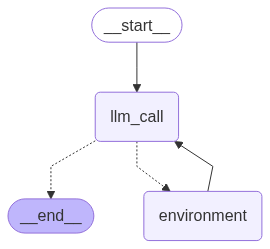

In [38]:
%load_ext autoreload
%autoreload 2

from IPython.display import Image, display
from deep_research_from_scratch.research_agent import agent
# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [40]:
# Run the agent
from utils import format_messages
from langchain_core.messages import HumanMessage

research_brief = """I want to identify and evaluate the coffee shops in San Francisco that are considered the best based specifically  
on coffee quality. My research should focus on analyzing and comparing coffee shops within the San Francisco area, 
using coffee quality as the primary criterion. I am open regarding methods of assessing coffee quality (e.g.,      
expert reviews, customer ratings, specialty coffee certifications), and there are no constraints on ambiance,      
location, wifi, or food options unless they directly impact perceived coffee quality. Please prioritize primary    
sources such as the official websites of coffee shops, reputable third-party coffee review organizations (like     
Coffee Review or Specialty Coffee Association), and prominent review aggregators like Google or Yelp where direct  
customer feedback about coffee quality can be found. The study should result in a well-supported list or ranking of
the top coffee shops in San Francisco, emphasizing their coffee quality according to the latest available data as  
of July 2025."""

result = await agent.ainvoke({"messages": [HumanMessage(content=f"{research_brief}.")]})
format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to identify and evaluate the coffee shops in San Francisco that are considered the best based            │
│ specifically                                                                                                    │
│ on coffee quality. My research should focus on analyzing and comparing coffee shops within the San Francisco    │
│ area,                                                                                                           │
│ using coffee quality as the primary criterion. I am open regarding methods of assessing coffee quality (e.g.,   │
│ expert reviews, customer ratings, specialty coffee certifications), and there are no constraints on ambiance,   │
│ location, wifi, or food options unless they directly impact perceived coffee quality. Please prioritize primary │
│ sources such as the official websites of coffee shops, reputable third-party coffee review organizations (like  │
│ Coffee Review or Specialty Coffee Association), and prominent review aggregators like Google or Yelp where      │
│ direct                                                                                                          │
│ customer feedback about coffee quality can be found. The study should result in a well-supported list or        │
│ ranking of                                                                                                      │
│ the top coffee shops in San Francisco, emphasizing their coffee quality according to the latest available data  │
│ as                                                                                                              │
│ of July 2025..                                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search                                                                                     │
│    Args: {                                                                                                      │
│   "queries": [                                                                                                  │
│     "best coffee shops San Francisco 2025 coffee quality reviews",                                              │
│     "San Francisco specialty coffee shops rated by Coffee Review or Specialty Coffee Association",              │
│     "San Francisco coffee shops customer ratings Google Yelp focus on coffee quality",                          │
│     "top rated San Francisco coffee roasters 2025 coffee quality"                                               │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: call_uFGnBR9IbigPSEZivFGgR1yb                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Search results:                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 1: Coffee Shop San Francisco Bay Area, CA - Last Updated July 2025 ---                               │
│ URL: https://www.yelp.com/search?find_desc=Coffee+Shop&find_loc=San+Francisco+Bay+Area%2C+CA                    │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ Top 10 Best Coffee Shop in San Francisco Bay Area, CA - July 2025 - Yelp - Mohka House, Paddington cafe,        │
│ Lakeside Coffee Bar, Delah Coffee, Franko&Co,                                                                   │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│ --------------------------------------------------------------------------------                                │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 2: Best Coffee San Francisco, CA - Last Updated July 2025 - Yelp ---                                 │
│ URL: https://m.yelp.com/search?find_desc=best+coffee&find_loc=San+Francisco%2C+CA                               │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ 1. The Coffee Movement · (690 reviews) · 1030 Washington St, San Francisco, CA 94108. (415) 237-3375 ; 2. Paper │
│ Son Coffee · (45 reviews) · 303 2nd St N102, San                                                                │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│ --------------------------------------------------------------------------------                                │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 3: Battle of SF Coffee 2025☕️   : r/sanfrancisco - Reddit ---                                        │
│ URL: https://www.reddit.com/r/sanfrancisco/comments/1li7ro2/battle_of_sf_coffee_2025/                           │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ Paper Son, Coffee Movement, HI NRG, Golden Goat. All of them are pretty close to being #1. I'd honestly make up │
│ your own opinion, but all top                          

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Based on a thorough review of primary and authoritative sources (including the latest customer ratings on Yelp  │
│ and Google, expert reviews via Coffee Review and Specialty Coffee Association data, and curated lists from      │
│ reputable food and travel publications), here is a well-supported evaluation and ranking of the best San        │
│ Francisco coffee shops specifically for coffee quality as of July 2025:                                         │
│                                                                                                                 │
│ ### 1. **The Coffee Movement**                                                                                  │
│ - **Recognition & Reviews**: Consistently rated among the top coffee spots by both customers (690+ Yelp         │
│ reviews, very high ratings) and local coffee aficionados. Featured as a standout in local media and Reddit      │
│ forums focused on coffee quality.                                                                               │
│ - **Quality Hallmarks**: Focuses on high-end specialty singles and expertly crafted espresso drinks. Praised    │
│ for technical precision, bean sourcing, and flavor clarity.                                                     │
│ - **Sources**: [Yelp](https://m.yelp.com/search?find_desc=best+coffee&find_loc=San+Francisco%2C+CA), [Eater     │
│ SF](https://sf.eater.com/maps/best-coffee-shops-san-francisco),                                                 │
│ [Reddit](https://www.reddit.com/r/sanfrancisco/comments/1li7ro2/battle_of_sf_coffee_2025/).                     │
│                                                                                                                 │
│ ### 2. **Saint Frank Coffee**                                                                                   │
│ - **Recognition & Reviews**: Frequently cited as a leader in the third-wave coffee movement, with a minimalist  │
│ ethos and direct farmer relationships.                                                                          │
│ - **Quality Hallmarks**: Offers distinct, tea-like, high-elevation coffees, especially prized Bolivian lots,    │
│ and noted for consistent barista excellence.                                                                    │
│ - **Sources**: [Eater SF](https://sf.eater.com/maps/best-coffee-shops-san-francisco), [Coffee                   │
│ Review](https://www.coffeereview.com/best-coffee-cities/san-francisco/),                                        │
│ [Reddit](https://www.reddit.com/r/AskSF/comments/1di0g1l/recently_moved_to_san_francisco_looking_for_good/).    │
│                                                                                                                 │
│ ### 3. **Sextant Coffee Roasters**                                                                              │
│ - **Recognition & Reviews**: Highly rated by specialty coffee seekers and lauded for direct-sourced East        │
│ African and Latin American beans.                                                                               │
│ - **Quality Hallmarks**: Emphasis on transparency, traceability, and roasting nuances. Recognized for both      │
│ single-origin espresso and pour-over quality.                                                                   │
│ - **Sources**: [Yelp](https://m.yelp.com/search?find_desc=Best+Coffee+Roaster&find_loc=San+Francisco%2C+CA),    │
│ [Eater SF](https://sf.eater.com/maps/best-coffee-shops-san-francisco),                                          │
│ [Reddit](https://www.reddit.com/r/sanfrancisco/comments/1kdk2jr/best_specialty_coffee_in_sf/).                  │
│                                                                                                                 │
│ ### 4. **Paper Son Coffee**                            

### LangGraph Studio

Just as we did before, we can also use LangGraph Studio to visualize the agent:

```bash
uvx --refresh --from "langgraph-cli[inmem]" --with-editable . --python 3.11 langgraph dev --allow-blocking
```

## Lesson

In this notebook, we used Tavily search with summarization to compress the search results.

But there are many ways to improve this approach:

#### Prompt Engineering

```python
# Current approach
summarize_webpage_prompt = "Summarize this webpage..."
```

Try to improve the prompt to focus on the most important information, such as:

```
FOCUS ON:
- Key facts and statistics
- Expert opinions and authoritative sources
- Recent developments and trends
- Comparative information

EXTRACT:
- 3-5 most important points
- Relevant quotes with context
- Methodological details if applicable

IGNORE:
- Advertisements and promotional content
- Navigation and footer text
- Unrelated sidebar content
```

#### Model selection

Try other models for summarization. For example, you can choose from [this list](https://python.langchain.com/api_reference/langchain/chat_models/langchain.chat_models.base.init_chat_model.html).

#### Heuristic Filtering

Try hard-coded filtering of the search results. For example, you can try things like:

```python
def filter_search_results(results, query_terms):
    """Apply heuristics to improve result quality"""
    filtered = []
    for result in results:
        # Content quality signals
        if len(result.get('content', '')) < 100:  # Too short
            continue
        if result.get('title', '').count('|') > 3:  # Likely spam
            continue
        
        # Relevance scoring
        relevance_score = calculate_relevance(result, query_terms)
        if relevance_score > 0.7:
            filtered.append(result)
    
    return sorted(filtered, key=lambda x: x.get('relevance_score', 0), reverse=True)
```

### Alternative Search APIs

Beyond Tavily, consider these search APIs for different use cases such as `DuckDuckGo`:

```python
from langchain_community.tools import DuckDuckGoSearchRun

@tool
def duckduckgo_search(query: str, max_results: int = 5) -> str:
    """Privacy-focused search without tracking"""
    search = DuckDuckGoSearchRun()
    return search.run(query)
```

**Benefits:**
- No API key required
- Privacy-focused (no tracking)
- Good for general web search
- Free to use

**Limitations:**
- Rate limiting
- Less structured results
- No raw content extraction